**Simple training without imputation i.e dropping all the rows having missing values**

**Performer: Pooja Pandit**

This code chunk performs a multi-output classification task to predict both Sex_F and ADHD_Outcome from brain imaging and metadata features. It:

1. Loads and merges multiple datasets (categorical, quantitative, connectome, and labels).

2. Cleans the data by dropping missing values.

3. Encodes and scales features, splitting the data into training and test sets.

4. Defines and trains three models: Random Forest, Logistic Regression, and LightGBM, each wrapped in a MultiOutputClassifier to predict two targets.

5. Evaluates model performance separately on ADHD and sex prediction.

6. Summarizes results in a comparison table based on accuracy.

In [1]:
# === Import libraries ===
import pandas as pd                   # Data loading and manipulation
import seaborn as sns                # For plotting (not used here, but typically for visualization)
import numpy as np                   # Numerical operations
import matplotlib.pyplot as plt      # Plotting
from sklearn.preprocessing import StandardScaler  # For feature scaling
from sklearn.preprocessing import LabelEncoder    # For encoding labels (not used here)
from sklearn.model_selection import train_test_split, cross_val_score, KFold  # For data splitting, model  and cross validation.
from sklearn.multioutput import MultiOutputClassifier  # For handling multiple target labels
from sklearn.ensemble import RandomForestClassifier     # Random Forest model
from sklearn.linear_model import LogisticRegression     # Logistic Regression model
from lightgbm import LGBMClassifier                     # LightGBM model
from sklearn.metrics import accuracy_score, classification_report  # Model evaluation metrics
import warnings  # For managing warning messages
warnings.filterwarnings('ignore')  # Suppress warnings for clean output

# === Load datasets ===
categorical_data = pd.read_excel("train_new/TRAIN_CATEGORICAL_METADATA_new.xlsx")       # Demographic data
quantitative_data = pd.read_excel("train_new/TRAIN_QUANTITATIVE_METADATA_new.xlsx")     # Numeric clinical and behavioral features
connectome_data = pd.read_csv("train_new/TRAIN_FUNCTIONAL_CONNECTOME_MATRICES_new_36P_Pearson.csv") # Functional brain connectome matrix
train_data = pd.read_excel("train_new/TRAINING_SOLUTIONS.xlsx")  # Ground-truth labels: ADHD_Outcome and Sex_F

# Print structure of target data
print(train_data.info())

# === Merge datasets on participant_id ===
merged_data = categorical_data.merge(quantitative_data, on='participant_id', how='inner')
merged_data = merged_data.merge(connectome_data, on='participant_id', how='inner')
merged_data = merged_data.merge(train_data, on='participant_id', how='inner')

# Check shape after merging
print(merged_data)
print("Shape after dropping missing values:", merged_data.shape)

# === Handle missing data ===
merged_data.isnull().sum()  # Summarize missing values
merged_data_clean = merged_data.dropna()  # Drop rows with missing data

print("Shape after dropping missing values:", merged_data_clean.shape)

# === Identify categorical columns ===
categorical_cols = merged_data_clean.select_dtypes(include='object').columns
print(categorical_cols)  # Useful if you want to encode them later (currently not encoded)

# === Separate features and targets ===
y = merged_data_clean[['Sex_F', 'ADHD_Outcome']]  # Multi-output target
X = merged_data_clean.drop(['participant_id', 'Sex_F', 'ADHD_Outcome'], axis=1)  # Drop ID and targets

# === Scale features ===
X_scaled = StandardScaler().fit_transform(X)  # Z-score normalization

# === Train-test split ===
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=108)

# === Define machine learning models ===
models = {
    'Random Forest': MultiOutputClassifier(RandomForestClassifier(n_estimators=100, random_state=108)),
    'Logistic Regression': MultiOutputClassifier(LogisticRegression(max_iter=1000)),
    'LightGBM': MultiOutputClassifier(LGBMClassifier(random_state=108))
}

# === Evaluate each model ===
results = []  # List to store accuracy results for each model

# Loop over each model (Random Forest, Logistic Regression, LightGBM)
for name, model in models.items():
    print(f"\nTraining {name}...")  # Inform which model is currently being trained

    model.fit(X_train, y_train)  # Train the multi-output model on training data

    y_pred = model.predict(X_test)  # Predict both ADHD and Sex_F on test data
    # y_pred is a 2D array: each row corresponds to a test sample,
    # with column 0 = ADHD_Outcome prediction, column 1 = Sex_F prediction

    # Calculate accuracy for ADHD outcome (first column)
    adhd_acc = accuracy_score(y_test['ADHD_Outcome'], y_pred[:, 0])

    # Calculate accuracy for Sex prediction (second column)
    sex_acc = accuracy_score(y_test['Sex_F'], y_pred[:, 1])

    # Append individual and average accuracies to the results list
    results.append({
        'Model': name,
        'ADHD_Accuracy': adhd_acc,                  # Accuracy for ADHD classification
        'Sex_Accuracy': sex_acc,                    # Accuracy for Sex classification
        'Average_Accuracy': np.mean([adhd_acc, sex_acc])  # Average of both as a composite metric
    })

    # Print detailed classification metrics: precision, recall, f1-score
    print(f"{name} ADHD Accuracy: {adhd_acc:.4f}, Sex Accuracy: {sex_acc:.4f}")
    print(classification_report(
        y_test, y_pred,
        target_names=['ADHD_Outcome', 'Sex_F'],  # Human-readable target names
        zero_division=0  # Prevent divide-by-zero warnings in report
    ))

# === Summarize all models ===
# Convert the list of model results to a DataFrame and sort by average accuracy
results_df = pd.DataFrame(results).sort_values(by='Average_Accuracy', ascending=False)

# Display the summary table comparing all models
print("\nModel Comparison Summary:")
print(results_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1213 entries, 0 to 1212
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   participant_id  1213 non-null   object
 1   ADHD_Outcome    1213 non-null   int64 
 2   Sex_F           1213 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 28.6+ KB
None
     participant_id  Basic_Demos_Enroll_Year  Basic_Demos_Study_Site  \
0      00aIpNTbG5uh                     2019                       4   
1      00fV0OyyoLfw                     2017                       1   
2      04X1eiS79T4B                     2017                       1   
3      05ocQutkURd6                     2018                       1   
4      06YUNBA9ZRLq                     2018                       1   
...             ...                      ...                     ...   
1208   zwjJWCRzKhDz                     2019                       4   
1209   zwXD5v17Rx01                     20

This following code chunks perform a multi-output classification task to predict both Sex_F and ADHD_Outcome from brain imaging and metadata features.

In [2]:
# --- Imports ---
# Import the joblib library, which is used for saving and loading Python objects efficiently.
# Commonly used to serialize trained machine learning models or pipelines.
import joblib

# Import PCA (Principal Component Analysis) from scikit-learn's decomposition module.
# PCA is a dimensionality reduction technique used to project high-dimensional data
# into a lower-dimensional space while preserving as much variance as possible.
from sklearn.decomposition import PCA

**Data Preparation and Feature Scaling**

1. The target variables (Sex_F, ADHD_Outcome) are separated from the features.

2. The feature column names are saved for use during test-time alignment.

3. Features are standardized using StandardScaler to improve model performance and enable principle component analysis (PCA).

**Performer: Pooja Pandit**

In [3]:
# Split the dataset into features and target labels
y = merged_data_clean[['Sex_F', 'ADHD_Outcome']]
X = merged_data_clean.drop(['participant_id', 'Sex_F', 'ADHD_Outcome'], axis=1)

# Save the list of feature column names for use during test-time alignment
joblib.dump(X.columns.tolist(), "train_columns.joblib")
print("Training feature columns saved.")

Training feature columns saved.


**Dimensionality Reduction via PCA**

1. PCA is applied to reduce feature dimensionality while retaining 98% of the variance.

2. The number of components needed to meet this threshold is automatically selected.

3. The final PCA transformer is saved and a variance plot is generated for visualization.

**Performer: Pooja Pandit**

Standardization applied and scaler saved.
PCA selected 565 components to retain 98.0% variance.
PCA applied and transformer saved.


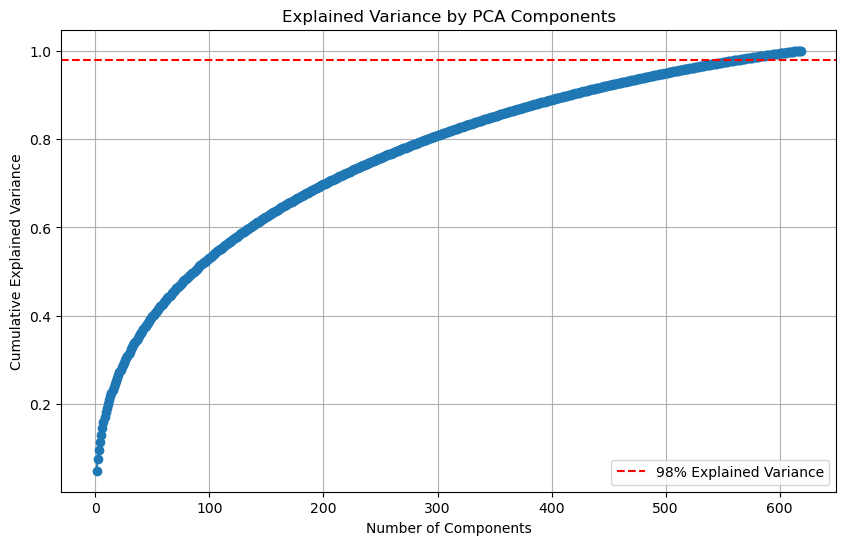

In [4]:
# =========================
# --- Standardization and PCA transformation ---
# =========================
try:
    scaler = StandardScaler()  # Initialize standard scaler
    X_scaled = scaler.fit_transform(X)  # Fit scaler to training features and transform them
    joblib.dump(scaler, "scaler.joblib")  # Save the scaler for use on test data
    print("Standardization applied and scaler saved.")  # Confirm success
except Exception as e:
    print("Error during standardization.")  # Error message if scaling fails
    print(e)
    raise

# PCA for 98% variance
try:
    target_variance = 0.98  # Set variance threshold for PCA
    pca_full = PCA(random_state=108)  # Initialize PCA object to determine optimal component count
    X_pca_full = pca_full.fit_transform(X_scaled)  # Fit PCA on scaled data
    explained_variance_ratio = np.cumsum(pca_full.explained_variance_ratio_)  # Compute cumulative variance explained
    n_components = np.argmax(explained_variance_ratio >= target_variance) + 1  # Find minimum components to retain 98% variance
    print(f"PCA selected {n_components} components to retain {target_variance*100:.1f}% variance.")  # Report chosen dimension

    pca_final = PCA(n_components=n_components, random_state=108)  # Initialize final PCA with selected components
    X_pca = pca_final.fit_transform(X_scaled)  # Apply PCA transformation
    joblib.dump(pca_final, "pca_transformer.joblib")  # Save final PCA transformer
    print("PCA applied and transformer saved.")  # Confirm

    # Plot variance
    plt.figure(figsize=(10,6))  # Set figure size
    plt.plot(np.arange(1, len(explained_variance_ratio)+1), explained_variance_ratio, marker='o')  # Plot variance
    plt.axhline(y=target_variance, color='r', linestyle='--', label=f'{int(target_variance*100)}% Explained Variance')  # Add threshold line
    plt.xlabel('Number of Components')  # Label x-axis
    plt.ylabel('Cumulative Explained Variance')  # Label y-axis
    plt.title('Explained Variance by PCA Components')  # Plot title
    plt.grid()  # Show grid
    plt.legend()  # Show legend
    plt.show()  # Display plot
except Exception as e:
    print("Error during PCA.")  # Catch PCA errors
    print(e)
    raise

**Model Definition and Cross-Validation**

1. Three base models are defined: Random Forest, Logistic Regression, and LightGBM.

2. Each model is wrapped in a MultiOutputClassifier to predict both labels simultaneously.

3. A custom function computes per-target accuracy.

4. 5-fold cross-validation is performed on each model using the PCA-transformed data.

5. Mean accuracies across folds are recorded for both ADHD and Sex prediction.

**Performer: Pooja Pandit**


Evaluating Random Forest...

Evaluating Logistic Regression...

Evaluating LightGBM...
[LightGBM] [Info] Number of positive: 166, number of negative: 329
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010447 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 93412
[LightGBM] [Info] Number of data points in the train set: 495, number of used features: 565
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.335354 -> initscore=-0.684070
[LightGBM] [Info] Start training from score -0.684070
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

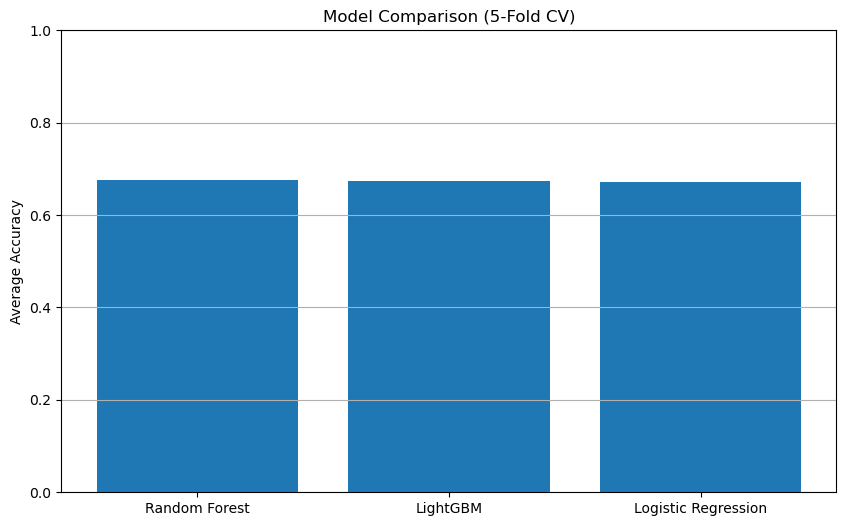

In [5]:
# =========================
# --- Model Training and Cross-Validation ---
# =========================
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=108),  # Random Forest model
    'Logistic Regression': LogisticRegression(max_iter=1000),  # Logistic Regression model
    'LightGBM': LGBMClassifier(random_state=108)  # LightGBM model
}

# Function to compute accuracy for each output separately
def multioutput_accuracy_per_target(y_true, y_pred):
    adhd_acc = accuracy_score(y_true[:, 1], y_pred[:, 1])  # Accuracy for ADHD
    sex_acc = accuracy_score(y_true[:, 0], y_pred[:, 0])  # Accuracy for Sex
    avg_acc = np.mean([adhd_acc, sex_acc])  # Average of both
    return adhd_acc, sex_acc, avg_acc

results = []  # Store model performance results
kf = KFold(n_splits=5, shuffle=True, random_state=108)  # 5-fold cross-validation setup

# Loop through each model
for name, base_model in models.items():
    print(f"\nEvaluating {name}...")  # Model being evaluated

    model = MultiOutputClassifier(base_model)  # Wrap model for multi-output prediction
    adhd_accuracies, sex_accuracies = [], []  # Store per-fold accuracies

    for train_idx, test_idx in kf.split(X_pca):  # Iterate over CV folds
        X_train_cv, X_test_cv = X_pca[train_idx], X_pca[test_idx]  # Split features
        y_train_cv, y_test_cv = y.values[train_idx], y.values[test_idx]  # Split targets

        model.fit(X_train_cv, y_train_cv)  # Train on fold
        y_pred_cv = model.predict(X_test_cv)  # Predict on fold

        adhd_acc, sex_acc, _ = multioutput_accuracy_per_target(y_test_cv, y_pred_cv)  # Evaluate
        adhd_accuracies.append(adhd_acc)
        sex_accuracies.append(sex_acc)

    mean_adhd_acc = np.mean(adhd_accuracies)  # Mean ADHD accuracy across folds
    mean_sex_acc = np.mean(sex_accuracies)  # Mean Sex accuracy across folds
    avg_acc = np.mean([mean_adhd_acc, mean_sex_acc])  # Combined average

    results.append({
        'Model': name,
        'ADHD_Accuracy': mean_adhd_acc,
        'Sex_Accuracy': mean_sex_acc,
        'Average_Accuracy': avg_acc
    })

# Show model performance
results_df = pd.DataFrame(results).sort_values(by='Average_Accuracy', ascending=False)  # Sort models by performance
print("\nModel Comparison Summary:")  # Print final table
print(results_df)

# Plot
plt.figure(figsize=(10,6))  # Bar plot setup
plt.bar(results_df['Model'], results_df['Average_Accuracy'])  # Plot average accuracy
plt.ylabel('Average Accuracy')
plt.title('Model Comparison (5-Fold CV)')
plt.ylim(0, 1)  # Fix y-axis scale
plt.grid(axis='y')
plt.show()

**Model Selection and Final Training**

1. The model with the highest average accuracy is selected as the best performer.

2. This best model is then retrained on the entire training set and saved for later use.

**Performer: Pooja Pandit**

In [6]:
# =========================
# --- Final Model Training and Saving ---
# =========================
try:
    best_model_name = results_df.iloc[0]['Model']  # Select best performing model
    print(f"\nBest model selected: {best_model_name}")  # Announce best model

    base_model_mapping = {
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=108),
        'Logistic Regression': LogisticRegression(max_iter=1000),
        'LightGBM': LGBMClassifier(random_state=108)
    }

    final_model = MultiOutputClassifier(base_model_mapping[best_model_name])  # Final model
    final_model.fit(X_pca, y)  # Retrain on full data
    joblib.dump(final_model, "random_forest_multioutput_model.joblib")  # Save model
    print("Best model retrained and saved successfully.")
except Exception as e:
    print("Error during final model training.")
    print(e)
    raise


Best model selected: Random Forest
Best model retrained and saved successfully.


**Test Data Loading and Preprocessing**

1. Test datasets are loaded and merged on participant_id.

2. Missing values in numeric columns are filled with column means.

3. Test features are aligned to match the training features using the saved column order.

**Performer: Pooja Pandit**

In [7]:
# =========================
# --- TEST DATA Loading and Preprocessing ---
# =========================

try:
    categorical_test = pd.read_excel("TEST/TEST_CATEGORICAL.xlsx")
    quantitative_test = pd.read_excel("TEST/TEST_QUANTITATIVE_METADATA.xlsx")
    connectome_test = pd.read_csv("TEST/TEST_FUNCTIONAL_CONNECTOME_MATRICES.csv")
    print("Test datasets loaded successfully.")
except Exception as e:
    print("Error loading test datasets.")
    print(e)
    raise

# Merge and clean test
try:
    # Merge the datasets
    test_data_clean = categorical_test.merge(quantitative_test, on='participant_id', how='inner')
    test_data_clean = test_data_clean.merge(connectome_test, on='participant_id', how='inner')

    # Replace NA values in numeric columns with column means
    numeric_cols = test_data_clean.select_dtypes(include=['number']).columns
    test_data_clean[numeric_cols] = test_data_clean[numeric_cols].fillna(test_data_clean[numeric_cols].mean())

    print("Test data merged and missing values imputed with column means.")

except Exception as e:
    print("Error during test data merging.")
    print(e)
    raise

# Preprocess test
try:
    participant_ids = test_data_clean['participant_id']
    X_test = test_data_clean.drop(['participant_id'], axis=1)

    train_columns = joblib.load("train_columns.joblib")
    X_test = X_test[train_columns]
    print("Test features aligned successfully.")
except Exception as e:
    print("\nError: Test features do not match training features.")
    print(e)
    raise

Test datasets loaded successfully.
Test data merged and missing values imputed with column means.
Test features aligned successfully.


**Test Data Transformation**

1. The saved scaler and PCA transformer are applied to the test dataset.

2. This ensures that test data is processed identically to training data.

**Performer: Pooja Pandit**

In [8]:
# =========================
# --- TEST DATA transformation ---
# =========================

try:
    scaler = joblib.load("scaler.joblib")  # Load saved scaler
    X_test_scaled = scaler.transform(X_test)  # Apply scaling
    print("Scaling applied successfully.")
except Exception as e:
    print("\nError during scaling of test set.")
    print(e)
    raise

try:
    pca_final = joblib.load("pca_transformer.joblib")  # Load PCA
    X_test_pca = pca_final.transform(X_test_scaled)  # Apply PCA
    print("PCA transformation applied successfully.")
except Exception as e:
    print("\nError during PCA transformation of test set.")
    print(e)
    raise

Scaling applied successfully.
PCA transformation applied successfully.


**Prediction and Submission File Generation**

1. The best-performing model is used to generate predictions on the test set.

2. Predictions for Sex_F and ADHD_Outcome are saved along with participant_id in a CSV file (test_predictions.csv) for final submission.

**Performer: Pooja Pandit**

In [9]:
# Predict
try:
    best_model = joblib.load("random_forest_multioutput_model.joblib")  # Load final model
    y_pred_test = best_model.predict(X_test_pca)  # Make predictions
    print("Prediction completed successfully.")
except Exception as e:
    print("\nError during prediction.")
    print(e)
    raise

# Save submission
try:
    submission_df = pd.DataFrame({
        'participant_id': participant_ids,  # Add back IDs
        'Sex_F_predicted': y_pred_test[:, 0],  # Sex predictions
        'ADHD_Outcome_predicted': y_pred_test[:, 1]  # ADHD predictions
    })
    submission_df.to_csv("test_predictions.csv", index=False)  # Save predictions
    print("\nPredictions saved to 'test_predictions.csv'.")
    print(submission_df.head())  # Preview first few rows
except Exception as e:
    print("\nError during saving predictions.")
    print(e)
    raise

Prediction completed successfully.

Predictions saved to 'test_predictions.csv'.
  participant_id  Sex_F_predicted  ADHD_Outcome_predicted
0   Cfwaf5FX7jWK                0                       1
1   vhGrzmvA3Hjq                0                       1
2   ULliyEXjy4OV                0                       1
3   LZfeAb1xMtql                0                       1
4   EnFOUv0YK1RG                0                       1


Model feature selection without imputation

The following code chunk implements a complete ML workflow where feature selection is integrated using feature importances from a Random Forest model. Here's the overall logic:

1. Data Preprocessing: Features and targets are separated, standardized, and saved.

2. Model-Based Feature Selection: A Random Forest is trained on ADHD labels, and features with high importance are retained. This step improves performance by removing irrelevant or noisy features.

3. Cross-Validation: Multiple classifiers (Random Forest, Logistic Regression, LightGBM) are evaluated using 5-fold cross-validation on the selected features.

4. Model Saving: The best-performing model is retrained on the full training set and saved.

5. Test Prediction: Test data is preprocessed using saved transformers and filtered by selected features. Predictions are made and saved to CSV.


**Performer: Mushaer Ahmed**

Training feature columns saved.
Standardization applied and scaler saved.


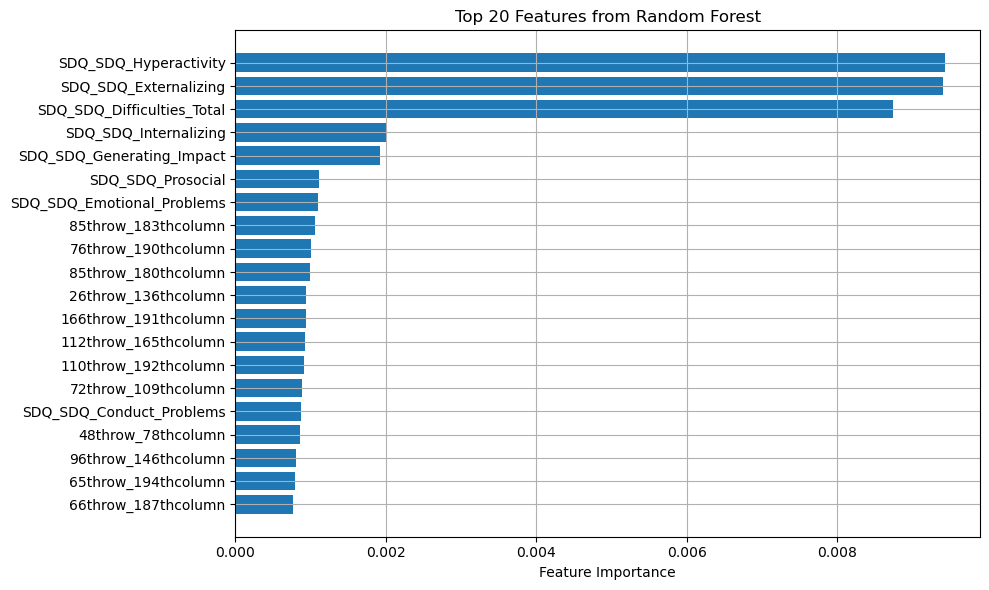

Selected 3 features with importance >= 0.004

Evaluating Random Forest...

Evaluating Logistic Regression...

Evaluating LightGBM...
[LightGBM] [Info] Number of positive: 166, number of negative: 329
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000343 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 61
[LightGBM] [Info] Number of data points in the train set: 495, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.335354 -> initscore=-0.684070
[LightGBM] [Info] Start training from score -0.684070
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightG

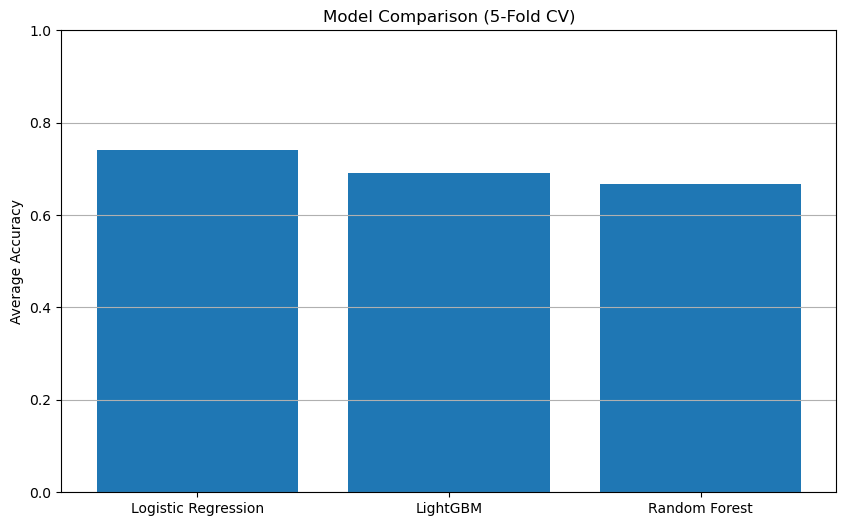


Best model selected: Logistic Regression
Best model retrained and saved successfully.
Test datasets loaded successfully.
Test data merged and missing values imputed with column means.
Test features aligned successfully.
Scaling applied successfully.
Manually selected test features using saved importance list.
Prediction completed successfully.

Predictions saved to 'test_predictions_final.csv'.
  participant_id  Sex_F_predicted  ADHD_Outcome_predicted
0   Cfwaf5FX7jWK                0                       1
1   vhGrzmvA3Hjq                1                       0
2   ULliyEXjy4OV                0                       0
3   LZfeAb1xMtql                0                       1
4   EnFOUv0YK1RG                0                       1


In [10]:
# Import feature selection and cross-validation utilities
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold  # Not used here, but useful for stratified splits

# Split labels (multi-output) and features
y = merged_data_clean[['Sex_F', 'ADHD_Outcome']]  # Multi-output target matrix
X = merged_data_clean.drop(['participant_id', 'Sex_F', 'ADHD_Outcome'], axis=1)  # Feature matrix excluding ID and targets

# Save training column names to ensure test-time alignment
joblib.dump(X.columns.tolist(), "train_columns.joblib")
print("Training feature columns saved.")

# =========================
# --- Standardization ---
# =========================
# Standardize feature values (mean=0, std=1)
try:
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)  # Fit and transform
    joblib.dump(scaler, "scaler.joblib")  # Save for use on test data
    print("Standardization applied and scaler saved.")
except Exception as e:
    print("Error during standardization.")
    print(e)
    raise

# =========================
# --- Model-Based Feature Selection ---
# =========================
try:
    rf = RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=108) #N-estimator is selelcted based on iteration(see next code chunk)
    rf.fit(X_scaled, y['ADHD_Outcome'])  # Fit on ADHD target only for feature importance

    # Get feature importances
    importances = rf.feature_importances_  # Extract feature importance scores
    feature_names = np.array(X.columns)  # Convert feature names to NumPy array

    # Visualize top 20 most important features
    top_n = 20
    indices = np.argsort(importances)[-top_n:]  # Indices of top 20 features

    plt.figure(figsize=(10, 6))
    plt.barh(range(top_n), importances[indices], align='center')  # Plot horizontal bars
    plt.yticks(range(top_n), feature_names[indices])
    plt.xlabel('Feature Importance')
    plt.title(f'Top {top_n} Features from Random Forest')
    plt.grid()
    plt.tight_layout()
    plt.show()
    
    # --- Manual thresholding ---
    # Thresholding: keep features with importance ≥ 0.004(this also selected by iteration and keeping what results best)
    importance_threshold = 0.004
    selected_mask = importances >= importance_threshold
    selected_features = feature_names[selected_mask]
    print(f"Selected {len(selected_features)} features with importance >= {importance_threshold}")

    # Filter X to selected features
    X_selected = X_scaled[:, selected_mask]  # Subset scaled features to selected ones

    # Save selected feature names and selector model
    joblib.dump(selected_features.tolist(), "selected_feature_names.joblib")
    joblib.dump(rf, "feature_selector_model.joblib")

except Exception as e:
    print("Error during feature selection and plotting.")
    print(e)
    raise

# =========================
# --- Model Training and Cross-Validation ---
# =========================
# Define dictionary of models to evaluate
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=108),  # Random Forest with 100 trees
    'Logistic Regression': LogisticRegression(max_iter=1000),  # Logistic Regression with increased iterations
    'LightGBM': LGBMClassifier(random_state=108)  # LightGBM classifier
}

# Custom function to compute individual and average accuracy for each target
def multioutput_accuracy_per_target(y_true, y_pred):
    adhd_acc = accuracy_score(y_true[:, 1], y_pred[:, 1])  # Accuracy for ADHD_Outcome
    sex_acc = accuracy_score(y_true[:, 0], y_pred[:, 0])   # Accuracy for Sex_F
    avg_acc = np.mean([adhd_acc, sex_acc])  # Average of both accuracies
    return adhd_acc, sex_acc, avg_acc

results = []  # Store evaluation results
kf = KFold(n_splits=5, shuffle=True, random_state=108)  # 5-fold cross-validation setup

# Loop over each model
for name, base_model in models.items():
    print(f"\nEvaluating {name}...")  # Indicate which model is being evaluated

    model = MultiOutputClassifier(base_model)  # Wrap base model to handle multiple outputs
    adhd_accuracies, sex_accuracies = [], []  # Track accuracies across folds

    # Cross-validation loop
    for train_idx, test_idx in kf.split(X_selected):
        X_train_cv, X_test_cv = X_selected[train_idx], X_selected[test_idx]  # Split features
        y_train_cv, y_test_cv = y.values[train_idx], y.values[test_idx]      # Split targets

        model.fit(X_train_cv, y_train_cv)  # Train model on training fold
        y_pred_cv = model.predict(X_test_cv)  # Predict on test fold

        # Compute accuracy per target
        adhd_acc, sex_acc, _ = multioutput_accuracy_per_target(y_test_cv, y_pred_cv)
        adhd_accuracies.append(adhd_acc)
        sex_accuracies.append(sex_acc)

    # Compute mean accuracies over all folds
    mean_adhd_acc = np.mean(adhd_accuracies)
    mean_sex_acc = np.mean(sex_accuracies)
    avg_acc = np.mean([mean_adhd_acc, mean_sex_acc])

    # Store results for this model
    results.append({
        'Model': name,
        'ADHD_Accuracy': mean_adhd_acc,
        'Sex_Accuracy': mean_sex_acc,
        'Average_Accuracy': avg_acc
    })

# Display results
results_df = pd.DataFrame(results).sort_values(by='Average_Accuracy', ascending=False)
print("\nModel Comparison Summary:")
print(results_df)

# Plot average accuracies
plt.figure(figsize=(10,6))
plt.bar(results_df['Model'], results_df['Average_Accuracy'])  # Bar plot of model accuracy
plt.ylabel('Average Accuracy')
plt.title('Model Comparison (5-Fold CV)')
plt.ylim(0, 1)
plt.grid(axis='y')
plt.show()

# =========================
# --- Final Model Training ---
# =========================

try:
    best_model_name = results_df.iloc[0]['Model']  # Select the model with highest average accuracy
    print(f"\nBest model selected: {best_model_name}")  # Display selected model

    # Map model name to actual estimator
    base_model_mapping = {
        'Random Forest': RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=108),
        'Logistic Regression': LogisticRegression(max_iter=1000, class_weight='balanced'),
        'LightGBM': LGBMClassifier(random_state=108)
    }

    final_model = MultiOutputClassifier(base_model_mapping[best_model_name])  # Wrap final model
    final_model.fit(X_selected, y)  # Train on full dataset
    joblib.dump(final_model, "random_forest_multioutput_model.joblib")  # Save model
    print("Best model retrained and saved successfully.")
except Exception as e:
    print("Error during final model training.")
    print(e)
    raise

# =========================
# --- TEST DATA Prediction and Manual Feature Filtering ---
# =========================

try:
    # Load all test datasets
    categorical_test = pd.read_excel("widsdatathon2025/TEST/TEST_CATEGORICAL.xlsx")
    quantitative_test = pd.read_excel("widsdatathon2025/TEST/TEST_QUANTITATIVE_METADATA.xlsx")
    connectome_test = pd.read_csv("widsdatathon2025/TEST/TEST_FUNCTIONAL_CONNECTOME_MATRICES.csv")
    print("Test datasets loaded successfully.")
except Exception as e:
    print("Error loading test datasets.")
    print(e)
    raise

try:
    # Merge test datasets on participant_id
    test_data_clean = categorical_test.merge(quantitative_test, on='participant_id', how='inner')
    test_data_clean = test_data_clean.merge(connectome_test, on='participant_id', how='inner')

    # Fill missing numeric values with column means
    numeric_cols = test_data_clean.select_dtypes(include=['number']).columns
    test_data_clean[numeric_cols] = test_data_clean[numeric_cols].fillna(test_data_clean[numeric_cols].mean())
    print("Test data merged and missing values imputed with column means.")
except Exception as e:
    print("Error during test data merging.")
    print(e)
    raise

try:
    participant_ids = test_data_clean['participant_id']  # Store participant IDs
    X_test = test_data_clean.drop(['participant_id'], axis=1)  # Drop ID column

    train_columns = joblib.load("train_columns.joblib")  # Load column order used during training
    X_test = X_test[train_columns]  # Align test columns
    print("Test features aligned successfully.")
except Exception as e:
    print("\nError: Test features do not match training features.")
    print(e)
    raise

try:
    scaler = joblib.load("scaler.joblib")  # Load saved scaler
    X_test_scaled = scaler.transform(X_test)  # Apply scaling to test data
    print("Scaling applied successfully.")
except Exception as e:
    print("\nError during scaling of test set.")
    print(e)
    raise

# Apply saved feature selection
try:
    selected_feature_names = joblib.load("selected_feature_names.joblib")  # Load selected feature list
    X_test_filtered = pd.DataFrame(X_test_scaled, columns=train_columns)[selected_feature_names]  # Filter columns
    X_test_selected = X_test_filtered.values  # Convert to NumPy array
    print("Manually selected test features using saved importance list.")
except Exception as e:
    print("\nError during manual test feature selection.")
    print(e)
    raise

# Predict
try:
    best_model = joblib.load("random_forest_multioutput_model.joblib")  # Load the best model trained earlier from disk
    y_pred_test = best_model.predict(X_test_selected)  # Make predictions on the selected test features
    print("Prediction completed successfully.")  # Notify that prediction worked
except Exception as e:
    print("\nError during prediction.")  # In case model loading or prediction fails
    print(e)  # Print the exception message
    raise  # Raise the error to halt execution

# Save submission
try:
    submission_df = pd.DataFrame({
        'participant_id': participant_ids,  # Include participant IDs from test set
        'Sex_F_predicted': y_pred_test[:, 0],  # Extract predicted values for Sex_F (column 0 of y_pred_test)
        'ADHD_Outcome_predicted': y_pred_test[:, 1]  # Extract predicted values for ADHD_Outcome (column 1)
    })  # Create a new DataFrame for submission

    submission_df.to_csv("test_predictions_final.csv", index=False)  # Save predictions to CSV without row index
    print("\nPredictions saved to 'test_predictions_final.csv'.")  # Confirm successful save
    print(submission_df.head())  # Display first few rows of the predictions
except Exception as e:
    print("\nError during saving predictions.")  # Catch block if saving fails
    print(e)  # Print error details
    raise  # Halt execution on failure

This code identifies and visualizes the most important features for predicting ADHD_Outcome using a Random Forest Classifier. It has been done to find the n_estimator value to include in erlier code chunk. The process involves:

1. Training a Random Forest model on the standardized feature set.

2. Extracting and sorting feature importance scores.

3. Selecting the top N features based on their importance.

4. Plotting a horizontal bar chart of the top contributing features.
**Performer: Mushaer Ahmed**

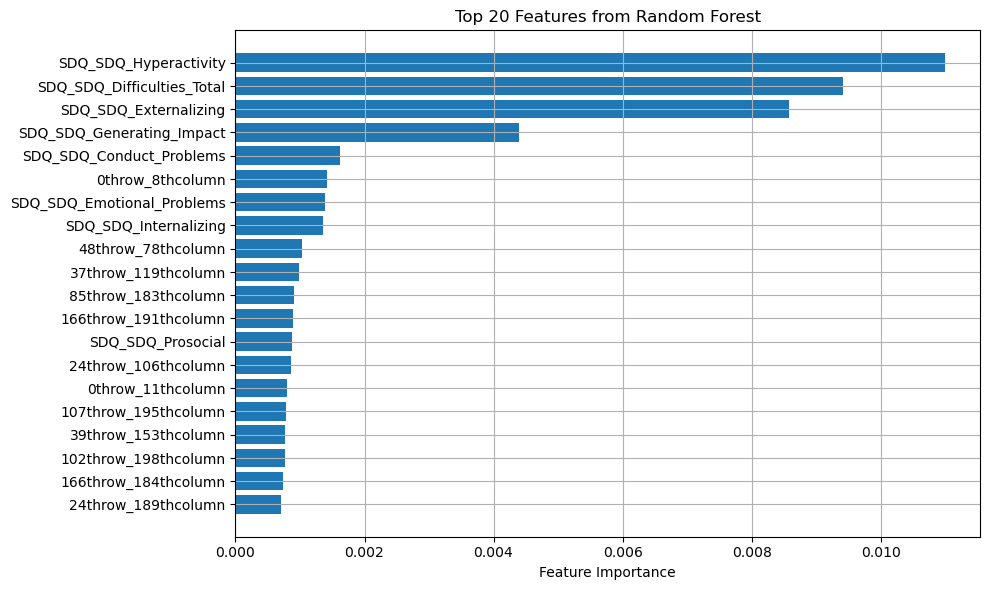

In [11]:
# =========================
# --- Feature Importance Plotting Using Random Forest ---
# =========================

# Step 1: Initialize Random Forest with a higher number of trees for stable importance scores
rf = RandomForestClassifier(n_estimators=200, random_state=108)  # 200 estimators = more stable importance estimates

# Step 2: Train the model using all standardized features and ADHD_Outcome as the target
rf.fit(X_scaled, y['ADHD_Outcome'])  # Only ADHD_Outcome is used for feature selection

# Step 3: Retrieve feature importance scores
importances = rf.feature_importances_  # Relative importance of each feature in the prediction
feature_names = X.columns  # Corresponding feature names for labeling the plot

# Step 4: Sort the top N most important features
top_n = 20  # Number of top features to visualize
indices = np.argsort(importances)[-top_n:]  # Get indices of the top N features (sorted ascending)

# Step 5: Plot feature importances
plt.figure(figsize=(10, 6))  # Set plot size
plt.barh(range(top_n), importances[indices], align='center')  # Horizontal bar chart
plt.yticks(range(top_n), [feature_names[i] for i in indices])  # Label each bar with the feature name
plt.xlabel('Feature Importance')  # X-axis label
plt.title(f'Top {top_n} Features from Random Forest')  # Plot title
plt.tight_layout()  # Adjust spacing to fit labels
plt.grid()  # Add gridlines for clarity
plt.show()  # Display the plot

This short code snippet is used to summarize the prediction results stored in test_predictions_final.csv. It reads the CSV file containing model predictions on the test dataset and then prints the count of predicted values for each class label in:

1. Sex_F_predicted (0 = no, 1 = yes)

2. ADHD_Outcome_predicted (0 = no ADHD, 1 = ADHD)
**Performer: Mushaer Ahmed**

In [12]:
# =========================
# --- Summarize Test Predictions ---
# =========================

# Load the prediction CSV file generated from the model
df = pd.read_csv("test_predictions_final.csv")  # Assumes the file contains columns: participant_id, Sex_F_predicted, ADHD_Outcome_predicted

# Display value counts for Sex_F predictions
print("Sex_F prediction counts:")  # Label for output
print(df["Sex_F_predicted"].value_counts())  # Count how many 0s and 1s were predicted for Sex_F

# Display value counts for ADHD_Outcome predictions
print("\nADHD_Outcome prediction counts:")  # Separate section label
print(df["ADHD_Outcome_predicted"].value_counts())  # Count how many 0s and 1s were predicted for ADHD_Outcome


Sex_F prediction counts:
Sex_F_predicted
0    179
1    125
Name: count, dtype: int64

ADHD_Outcome prediction counts:
ADHD_Outcome_predicted
1    191
0    113
Name: count, dtype: int64


This chunk shows the relative distribution (proportions) of the two target variables — Sex_F and ADHD_Outcome — in the training dataset (y). It uses .value_counts(normalize=True) to compute the percentage share of each class (0 or 1) rather than raw counts.
**Performer: Mushaer Ahmed**

In [13]:
# =========================
# --- Class Distribution in Training Data ---
# =========================

# Print normalized class distribution for Sex_F
print("Sex_F distribution:")  # Label output section for clarity
print(y["Sex_F"].value_counts(normalize=True))  # Show proportion of 0s and 1s (e.g., male vs female)

# Print normalized class distribution for ADHD_Outcome
print("ADHD_Outcome distribution:")  # Label for second target
print(y["ADHD_Outcome"].value_counts(normalize=True))  # Show proportion of ADHD vs non-ADHD


Sex_F distribution:
Sex_F
0    0.66559
1    0.33441
Name: proportion, dtype: float64
ADHD_Outcome distribution:
ADHD_Outcome
1    0.688207
0    0.311793
Name: proportion, dtype: float64


This code uses classification_report() from sklearn.metrics to generate a detailed performance summary for a binary classifier — in this case, for predicting Sex_F.
**Performer: Mushaer Ahmed**

In [14]:
# =========================
# --- Classification Report: Sex_F (0 = Not Female, 1 = Female) ---
# =========================

# Print classification report specifically for the Sex_F target
# 0 = Not Female, 1 = Female
print(classification_report(
    y_test['Sex_F'],        # True labels for Sex_F
    y_pred[:, 1],           # Predicted labels for Sex_F (column 1 of multi-output)
    target_names=['Not Female', 'Female']  # Custom class labels to clarify 0 and 1 meaning
))

              precision    recall  f1-score   support

  Not Female       0.47      0.18      0.26        83
      Female       0.26      0.59      0.36        41

    accuracy                           0.31       124
   macro avg       0.36      0.38      0.31       124
weighted avg       0.40      0.31      0.29       124



This code visualizes confusion matrices for two binary classification tasks:

1. Sex_F (0 = Not Female, 1 = Female)

2. ADHD_Outcome (0 = No ADHD, 1 = ADHD)

The confusion matrix shows how many predictions were correct vs incorrect, broken down by class.

**Performer: Mushaer Ahmed**

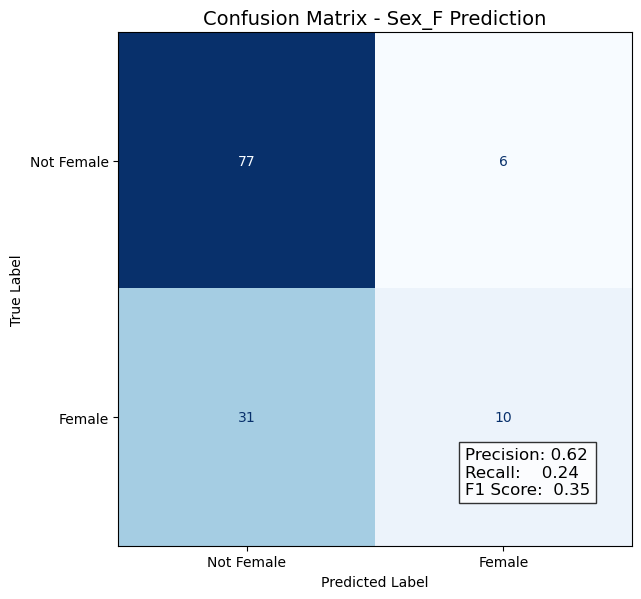

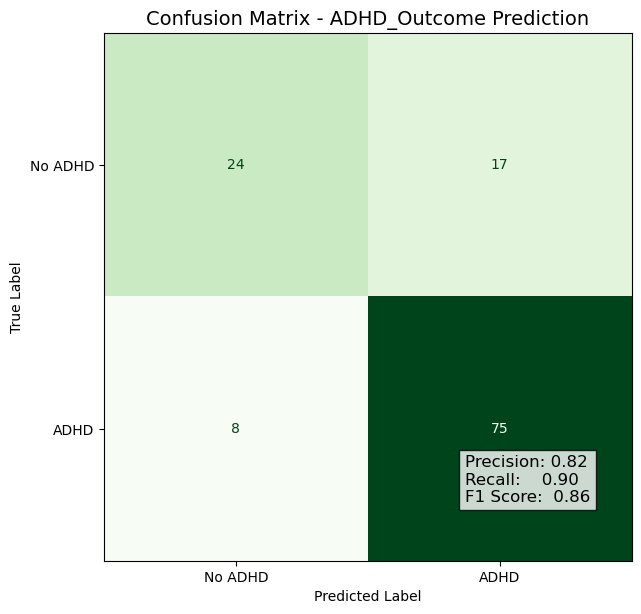

In [15]:
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    precision_score, recall_score, f1_score
)
import matplotlib.pyplot as plt

# =========================
# --- Confusion Matrix with Metrics: Sex_F ---
# =========================
try:
    y_true_sex = y_test['Sex_F'].values          # True labels for Sex_F (0 = Not Female, 1 = Female)
    y_pred_sex = y_pred[:, 0]                    # Predicted labels for Sex_F

    cm_sex = confusion_matrix(y_true_sex, y_pred_sex)  # Compute confusion matrix

    # Calculate precision, recall, F1 for Female (positive class = 1)
    precision_sex = precision_score(y_true_sex, y_pred_sex, zero_division=0)
    recall_sex = recall_score(y_true_sex, y_pred_sex, zero_division=0)
    f1_sex = f1_score(y_true_sex, y_pred_sex, zero_division=0)

    # Create and plot confusion matrix with display labels
    disp_sex = ConfusionMatrixDisplay(
        confusion_matrix=cm_sex,
        display_labels=['Not Female', 'Female']
    )

    fig, ax = plt.subplots(figsize=(6.5, 6.5))
    disp_sex.plot(ax=ax, cmap='Blues', colorbar=False)

    metrics_text_sex = (
        f'Precision: {precision_sex:.2f}\n'
        f'Recall:    {recall_sex:.2f}\n'
        f'F1 Score:  {f1_sex:.2f}'
    )
    plt.title("Confusion Matrix - Sex_F Prediction", fontsize=14)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.gcf().text(0.72, 0.2, metrics_text_sex, fontsize=12, bbox=dict(facecolor='white', alpha=0.8))

    plt.tight_layout()
    plt.show()

except Exception as e:
    print("Error plotting enhanced Sex_F confusion matrix:", e)
    
# =========================
# --- Confusion Matrix with Metrics: ADHD_Outcome ---
# =========================
try:
    y_true_adhd = y_test['ADHD_Outcome'].values  # True labels for ADHD
    y_pred_adhd = y_pred[:, 1]                   # Predicted labels for ADHD

    cm_adhd = confusion_matrix(y_true_adhd, y_pred_adhd)  # Confusion matrix

    # Compute metrics for ADHD (positive class = 1)
    precision_adhd = precision_score(y_true_adhd, y_pred_adhd, zero_division=0)
    recall_adhd = recall_score(y_true_adhd, y_pred_adhd, zero_division=0)
    f1_adhd = f1_score(y_true_adhd, y_pred_adhd, zero_division=0)

    disp_adhd = ConfusionMatrixDisplay(
        confusion_matrix=cm_adhd,
        display_labels=['No ADHD', 'ADHD']
    )

    fig, ax = plt.subplots(figsize=(6.5, 6.5))
    disp_adhd.plot(ax=ax, cmap='Greens', colorbar=False)

    metrics_text_adhd = (
        f'Precision: {precision_adhd:.2f}\n'
        f'Recall:    {recall_adhd:.2f}\n'
        f'F1 Score:  {f1_adhd:.2f}'
    )
    plt.title("Confusion Matrix - ADHD_Outcome Prediction", fontsize=14)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.gcf().text(0.72, 0.2, metrics_text_adhd, fontsize=12, bbox=dict(facecolor='white', alpha=0.8))

    plt.tight_layout()
    plt.show()

except Exception as e:
    print("Error plotting enhanced ADHD_Outcome confusion matrix:", e)
    

**Simple training with imputation**
As previously, we dropped missing values (entire row), we are now exploring impuation methods to approximate missing values and run the model again to see whether results improve or not.

This code block handles missing data imputation and dataset merging. Specifically:

1. It applies KNN imputation (KNNImputer) to fill missing values in quantitative features, excluding the participant_id.

2. It fills missing values in categorical features using the mode (most frequent value).

3. After imputation, it merges the cleaned categorical_data, quantitative_data, connectome_data, and train_data into a single merged_data_impute dataset using participant_id as the key.

**Performer: Neha Chaudhari, Mushaer Ahmed and Pooja Pandit** (this is a combined effort for exploring different ideas, so separtely mentioning performers for code blocks is avoided)

In [16]:
# =========================
# --- Load Libraries and Training Datasets (Annotated) ---
# =========================
from sklearn.model_selection import train_test_split  # For splitting data into train/test sets
from sklearn.impute import KNNImputer  # For handling missing values using K-nearest neighbors


# Load categorical metadata (e.g., age group, site, gender in object form)
categorical_data = pd.read_excel("train_new/TRAIN_CATEGORICAL_METADATA_new.xlsx")

# Load numerical metadata (e.g., clinical scores, behavior metrics)
quantitative_data = pd.read_excel("train_new/TRAIN_QUANTITATIVE_METADATA_new.xlsx")

# Load connectome matrix data (e.g., brain connectivity as Pearson correlation values)
connectome_data = pd.read_csv("train_new/TRAIN_FUNCTIONAL_CONNECTOME_MATRICES_new_36P_Pearson.csv")

# Load target variables (e.g., labels for ADHD and Sex_F classification)
train_data = pd.read_excel("train_new/TRAINING_SOLUTIONS.xlsx")

# Display structure of the label data: column names, types, non-null counts
print(train_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1213 entries, 0 to 1212
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   participant_id  1213 non-null   object
 1   ADHD_Outcome    1213 non-null   int64 
 2   Sex_F           1213 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 28.6+ KB
None


In [17]:
# =========================
# --- Missing Value Imputation and Dataset Merge ---
# =========================

# Separate participant_id before imputation
participant_id = quantitative_data['participant_id']  # Save IDs to restore after imputation

# Drop ID column so it doesn't affect distance calculations during KNN imputation
quant_data_num = quantitative_data.drop(columns=['participant_id'])

# Apply KNN imputation to fill missing numerical values based on 5 nearest neighbors
imputer = KNNImputer(n_neighbors=5)
quantitative_data = pd.DataFrame(
    imputer.fit_transform(quant_data_num),  # Impute the data
    columns=quant_data_num.columns          # Keep original column names
)

# Restore participant_id column after imputation
quantitative_data['participant_id'] = participant_id.values

# Verify that all missing values were filled
print(quantitative_data.isnull().sum())  # Should print all zeros if imputation was successful

# Impute missing values in categorical features using the mode (most frequent value)
for col in categorical_data.columns:
    if categorical_data[col].isnull().any():  # Check for missing values in column
        categorical_data[col].fillna(categorical_data[col].mode()[0], inplace=True)  # Replace with mode

EHQ_EHQ_Total                 0
ColorVision_CV_Score          0
APQ_P_APQ_P_CP                0
APQ_P_APQ_P_ID                0
APQ_P_APQ_P_INV               0
APQ_P_APQ_P_OPD               0
APQ_P_APQ_P_PM                0
APQ_P_APQ_P_PP                0
SDQ_SDQ_Conduct_Problems      0
SDQ_SDQ_Difficulties_Total    0
SDQ_SDQ_Emotional_Problems    0
SDQ_SDQ_Externalizing         0
SDQ_SDQ_Generating_Impact     0
SDQ_SDQ_Hyperactivity         0
SDQ_SDQ_Internalizing         0
SDQ_SDQ_Peer_Problems         0
SDQ_SDQ_Prosocial             0
MRI_Track_Age_at_Scan         0
participant_id                0
dtype: int64


In [18]:
# Merge all datasets using participant_id
merged_data_impute = categorical_data.merge(quantitative_data, on='participant_id', how='inner')  # Merge 1
merged_data_impute = merged_data_impute.merge(connectome_data, on='participant_id', how='inner')  # Merge 2
merged_data_impute = merged_data_impute.merge(train_data, on='participant_id', how='inner')        # Merge 3 (labels)

# Print shape of final merged dataset after imputations
print("Shape after imputing the missing values:", merged_data_impute.shape)

# Identify and print object-type (categorical) columns for encoding
categorical_cols = merged_data_impute.select_dtypes(include='object').columns
print(categorical_cols)

Shape after imputing the missing values: (1213, 19930)
Index(['participant_id'], dtype='object')


In [19]:
# =========================
# --- Model Training and Evaluation Pipeline ---
# =========================

# Define multi-output target variable (Sex_F and ADHD_Outcome)
y = merged_data_impute[['Sex_F', 'ADHD_Outcome']]  # Target labels for both outputs

# Drop ID and target columns from feature matrix
X = merged_data_impute.drop(['participant_id', 'Sex_F', 'ADHD_Outcome'], axis=1)  # Input features only

# Standardize features to zero mean and unit variance
X_scaled = StandardScaler().fit_transform(X)  # Helps improve model performance and convergence

# Split standardized data into training and testing subsets (80/20 split)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=108  # Use fixed seed for reproducibility
)

# --- Define base models, each wrapped to support multi-output prediction ---
models = {
    'Random Forest': MultiOutputClassifier(RandomForestClassifier(n_estimators=100, random_state=108)),
    'Logistic Regression': MultiOutputClassifier(LogisticRegression(max_iter=1000)),
    'LightGBM': MultiOutputClassifier(LGBMClassifier(random_state=108))
}

# --- Evaluate each model on the test set ---
results = []  # Initialize results list to store evaluation outcomes

# Loop over each model in the dictionary
for name, model in models.items():
    print(f"\nTraining {name}...")  # Display model name being trained
    model.fit(X_train, y_train)  # Fit the model on training data
    y_pred = model.predict(X_test)  # Predict targets on test data

    # Compute accuracy for each target separately
    adhd_acc = accuracy_score(y_test['ADHD_Outcome'], y_pred[:, 0])  # ADHD accuracy (first column)
    sex_acc = accuracy_score(y_test['Sex_F'], y_pred[:, 1])  # Sex_F accuracy (second column)

    # Store model performance results
    results.append({
        'Model': name,
        'ADHD_Accuracy': adhd_acc,
        'Sex_Accuracy': sex_acc,
        'Average_Accuracy': np.mean([adhd_acc, sex_acc])  # Mean of both accuracies
    })

    # Print classification report for precision, recall, and F1-score
    print(f"{name} ADHD Accuracy: {adhd_acc:.4f}, Sex Accuracy: {sex_acc:.4f}")
    print(classification_report(y_test, y_pred, target_names=['ADHD_Outcome', 'Sex_F'], zero_division=0))

# --- Summarize and display model performance ---
results_df = pd.DataFrame(results).sort_values(by='Average_Accuracy', ascending=False)  # Sort by average accuracy
print("\nModel Comparison Summary:")
print(results_df)  # Display performance comparison across models


Training Random Forest...
Random Forest ADHD Accuracy: 0.3745, Sex Accuracy: 0.3292
              precision    recall  f1-score   support

ADHD_Outcome       0.18      0.03      0.05        73
       Sex_F       0.65      0.97      0.78       157

   micro avg       0.63      0.67      0.65       230
   macro avg       0.42      0.50      0.41       230
weighted avg       0.50      0.67      0.55       230
 samples avg       0.62      0.54      0.56       230


Training Logistic Regression...
Logistic Regression ADHD Accuracy: 0.4815, Sex Accuracy: 0.3909
              precision    recall  f1-score   support

ADHD_Outcome       0.48      0.74      0.58        73
       Sex_F       0.72      0.63      0.67       157

   micro avg       0.61      0.67      0.64       230
   macro avg       0.60      0.69      0.63       230
weighted avg       0.64      0.67      0.64       230
 samples avg       0.49      0.52      0.49       230


Training LightGBM...
[LightGBM] [Info] Number of positi

This following code chunks perform a multi-output classification task to predict both Sex_F and ADHD_Outcome from brain imaging and metadata features. PCA is used for feature dimensionality reduction. 

Training feature columns saved.
Standardization applied and scaler saved.
PCA selected 1068 components to retain 98.0% variance.
PCA applied and transformer saved.


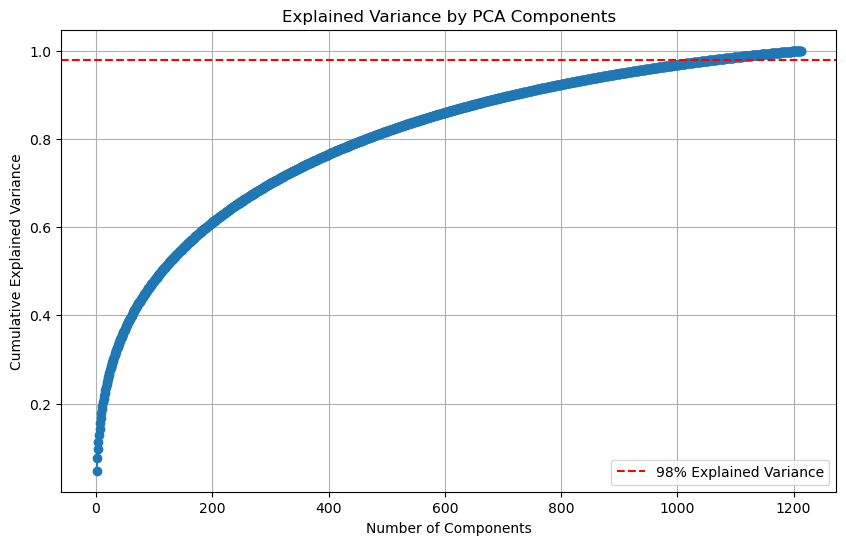


Evaluating Random Forest...

Evaluating Logistic Regression...

Evaluating LightGBM...
[LightGBM] [Info] Number of positive: 343, number of negative: 627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.086262 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 272340
[LightGBM] [Info] Number of data points in the train set: 970, number of used features: 1068
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.353608 -> initscore=-0.603216
[LightGBM] [Info] Start training from score -0.603216
[LightGBM] [Info] Number of positive: 674, number of negative: 296
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.090639 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 272340
[LightGBM] [Info] Number of data points in the train set: 970, number of used features: 1068
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.694845 -> in

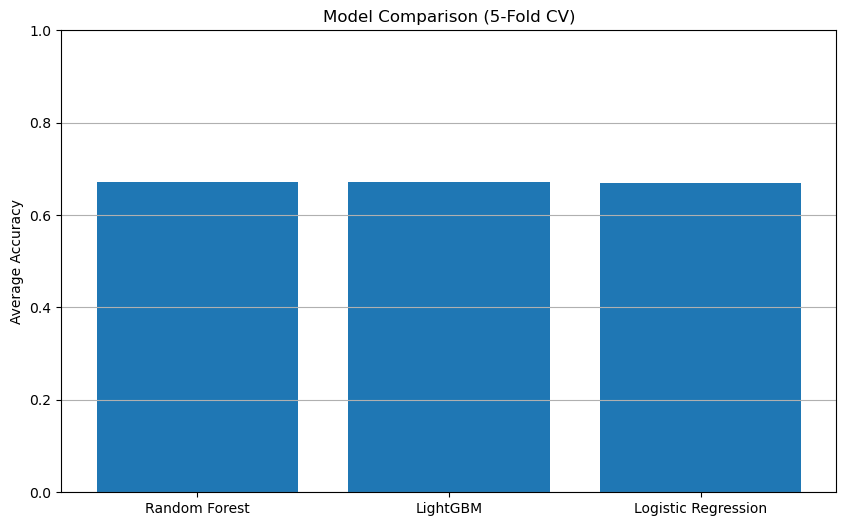


Best model selected: Random Forest
Best model retrained and saved successfully.
Test datasets loaded successfully.
Test data merged and cleaned.
Test features aligned successfully.
Scaling applied successfully.
PCA transformation applied successfully.
Prediction completed successfully.

Predictions saved to 'test_predictions.csv'.
  participant_id  Sex_F_predicted  ADHD_Outcome_predicted
0   Cfwaf5FX7jWK                0                       1
2   ULliyEXjy4OV                0                       1
3   LZfeAb1xMtql                0                       1
4   EnFOUv0YK1RG                0                       1
6   PRKZcnOgqcuk                0                       1


In [20]:
# =========================
# --- Feature/Target Split ---
# =========================
y = merged_data_impute[['Sex_F', 'ADHD_Outcome']]  # Define target matrix with two binary outputs
X = merged_data_impute.drop(['participant_id', 'Sex_F', 'ADHD_Outcome'], axis=1)  # Define feature matrix
joblib.dump(X.columns.tolist(), "train_columns.joblib")  # Save column names for test-time alignment
print("Training feature columns saved.")


# =========================
# --- Standardization and PCA ---
# =========================
try:
    scaler = StandardScaler()  # Initialize the scaler
    X_scaled = scaler.fit_transform(X)  # Standardize training features
    joblib.dump(scaler, "scaler.joblib")  # Save fitted scaler
    print("Standardization applied and scaler saved.")
except Exception as e:
    print("Error during standardization.")
    print(e)
    raise  # Stop if error occurs

# PCA for 98% variance
try:
    target_variance = 0.98  # Target: retain 98% variance
    pca_full = PCA(random_state=108)  # Full PCA to calculate explained variance
    X_pca_full = pca_full.fit_transform(X_scaled)  # Fit PCA on scaled features
    explained_variance_ratio = np.cumsum(pca_full.explained_variance_ratio_)  # Cumulative variance
    n_components = np.argmax(explained_variance_ratio >= target_variance) + 1  # Smallest # of components ≥ 98%
    print(f"PCA selected {n_components} components to retain {target_variance*100:.1f}% variance.")

    pca_final = PCA(n_components=n_components, random_state=108)  # Final PCA with optimal component count
    X_pca = pca_final.fit_transform(X_scaled)  # Apply PCA transformation
    joblib.dump(pca_final, "pca_transformer.joblib")  # Save PCA transformer
    print("PCA applied and transformer saved.")

    # Plot explained variance
    plt.figure(figsize=(10,6))  # Set plot size
    plt.plot(np.arange(1, len(explained_variance_ratio)+1), explained_variance_ratio, marker='o')  # Line plot
    plt.axhline(y=target_variance, color='r', linestyle='--', label=f'{int(target_variance*100)}% Explained Variance')  # Threshold line
    plt.xlabel('Number of Components')  # X-axis label
    plt.ylabel('Cumulative Explained Variance')  # Y-axis label
    plt.title('Explained Variance by PCA Components')  # Plot title
    plt.grid()  # Add grid
    plt.legend()  # Show legend
    plt.show()  # Display plot
except Exception as e:
    print("Error during PCA.")
    print(e)
    raise


# =========================
# --- Model Training and Cross-Validation ---
# =========================
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=108),  # Tree-based ensemble
    'Logistic Regression': LogisticRegression(max_iter=1000),  # Linear classifier
    'LightGBM': LGBMClassifier(random_state=108)  # Boosted trees
}

# Helper function: returns accuracy for ADHD, Sex_F, and their average
def multioutput_accuracy_per_target(y_true, y_pred):
    adhd_acc = accuracy_score(y_true[:, 1], y_pred[:, 1])  # ADHD column
    sex_acc = accuracy_score(y_true[:, 0], y_pred[:, 0])  # Sex_F column
    avg_acc = np.mean([adhd_acc, sex_acc])  # Average
    return adhd_acc, sex_acc, avg_acc

results = []  # Store performance results
kf = KFold(n_splits=5, shuffle=True, random_state=108)  # 5-fold cross-validation

for name, base_model in models.items():  # Iterate over model options
    print(f"\nEvaluating {name}...")  # Model name

    model = MultiOutputClassifier(base_model)  # Wrap model for dual output
    adhd_accuracies, sex_accuracies = [], []  # Initialize lists

    for train_idx, test_idx in kf.split(X_pca):  # Split into folds
        X_train_cv, X_test_cv = X_pca[train_idx], X_pca[test_idx]  # Features
        y_train_cv, y_test_cv = y.values[train_idx], y.values[test_idx]  # Labels

        model.fit(X_train_cv, y_train_cv)  # Train model
        y_pred_cv = model.predict(X_test_cv)  # Predict on fold

        adhd_acc, sex_acc, _ = multioutput_accuracy_per_target(y_test_cv, y_pred_cv)  # Evaluate
        adhd_accuracies.append(adhd_acc)
        sex_accuracies.append(sex_acc)

    # Average fold results
    mean_adhd_acc = np.mean(adhd_accuracies)
    mean_sex_acc = np.mean(sex_accuracies)
    avg_acc = np.mean([mean_adhd_acc, mean_sex_acc])

    results.append({
        'Model': name,
        'ADHD_Accuracy': mean_adhd_acc,
        'Sex_Accuracy': mean_sex_acc,
        'Average_Accuracy': avg_acc
    })

# Show model performance
results_df = pd.DataFrame(results).sort_values(by='Average_Accuracy', ascending=False)
print("\nModel Comparison Summary:")
print(results_df)

# Plot
plt.figure(figsize=(10,6))
plt.bar(results_df['Model'], results_df['Average_Accuracy'])
plt.ylabel('Average Accuracy')
plt.title('Model Comparison (5-Fold CV)')
plt.ylim(0, 1)
plt.grid(axis='y')
plt.show()

# =========================
# --- Final Model Training ---
# =========================
try:
    best_model_name = results_df.iloc[0]['Model']  # Select best model by accuracy
    print(f"\nBest model selected: {best_model_name}")

    base_model_mapping = {
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=108),
        'Logistic Regression': LogisticRegression(max_iter=1000),
        'LightGBM': LGBMClassifier(random_state=108)
    }

    final_model = MultiOutputClassifier(base_model_mapping[best_model_name])  # Wrap best model
    final_model.fit(X_pca, y)  # Retrain on all training data
    joblib.dump(final_model, "random_forest_multioutput_model.joblib")  # Save model
    print("Best model retrained and saved successfully.")
except Exception as e:
    print("Error during final model training.")
    print(e)
    raise

# =========================
# --- TEST DATA Prediction ---
# =========================
try:
    categorical_test = pd.read_excel("TEST/TEST_CATEGORICAL.xlsx")
    quantitative_test = pd.read_excel("TEST/TEST_QUANTITATIVE_METADATA.xlsx")
    connectome_test = pd.read_csv("TEST/TEST_FUNCTIONAL_CONNECTOME_MATRICES.csv")
    print("Test datasets loaded successfully.")
except Exception as e:
    print("Error loading test datasets.")
    print(e)
    raise

# Merge and clean test
try:
    test_data_clean = categorical_test.merge(quantitative_test, on='participant_id', how='inner')
    test_data_clean = test_data_clean.merge(connectome_test, on='participant_id', how='inner')
    test_data_clean = test_data_clean.dropna()
    print("Test data merged and cleaned.")
except Exception as e:
    print("Error during test data merging.")
    print(e)
    raise

# Preprocess test
try:
    participant_ids = test_data_clean['participant_id']
    X_test = test_data_clean.drop(['participant_id'], axis=1)

    train_columns = joblib.load("train_columns.joblib") # Load feature order
    X_test = X_test[train_columns] # Align columns
    print("Test features aligned successfully.")
except Exception as e:
    print("\nError: Test features do not match training features.")
    print(e)
    raise

try:
    scaler = joblib.load("scaler.joblib")
    X_test_scaled = scaler.transform(X_test)
    print("Scaling applied successfully.")
except Exception as e:
    print("\nError during scaling of test set.")
    print(e)
    raise

try:
    pca_final = joblib.load("pca_transformer.joblib")
    X_test_pca = pca_final.transform(X_test_scaled)
    print("PCA transformation applied successfully.")
except Exception as e:
    print("\nError during PCA transformation of test set.")
    print(e)
    raise

# Predict
try:
    best_model = joblib.load("random_forest_multioutput_model.joblib")
    y_pred_test = best_model.predict(X_test_pca)
    print("Prediction completed successfully.")
except Exception as e:
    print("\nError during prediction.")
    print(e)
    raise

# Save submission
try:
    submission_df = pd.DataFrame({
        'participant_id': participant_ids,
        'Sex_F_predicted': y_pred_test[:, 0],
        'ADHD_Outcome_predicted': y_pred_test[:, 1]
    })
    submission_df.to_csv("test_predictions.csv", index=False)
    print("\nPredictions saved to 'test_predictions.csv'.")
    print(submission_df.head())
except Exception as e:
    print("\nError during saving predictions.")
    print(e)
    raise


Model-based feature selection

Training feature columns saved.
Standardization applied and scaler saved.


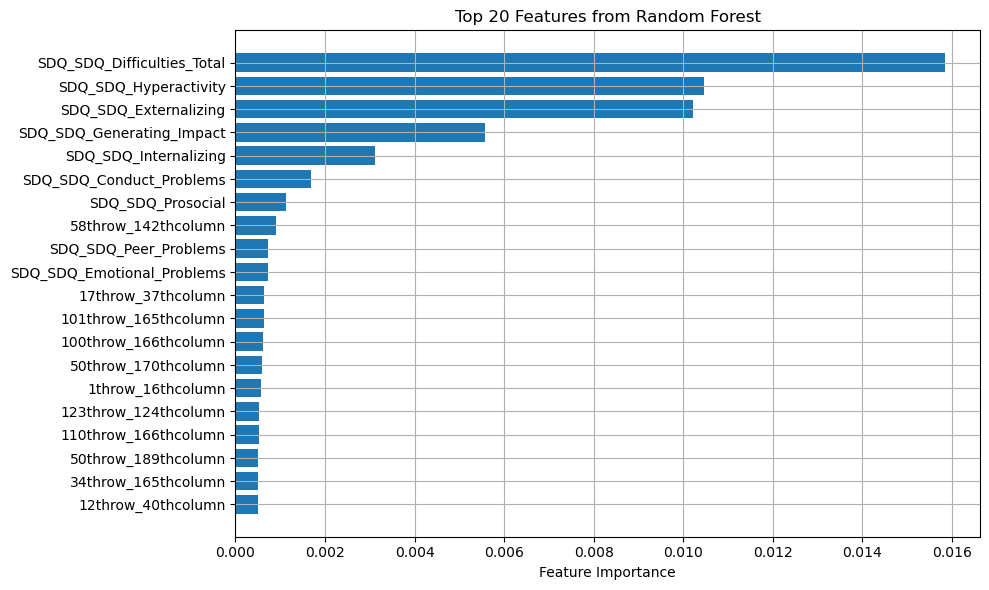

Selected 4 features with importance >= 0.004

Evaluating Random Forest...

Evaluating Logistic Regression...

Evaluating LightGBM...
[LightGBM] [Info] Number of positive: 343, number of negative: 627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000288 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78
[LightGBM] [Info] Number of data points in the train set: 970, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.353608 -> initscore=-0.603216
[LightGBM] [Info] Start training from score -0.603216
[LightGBM] [Info] Number of positive: 674, number of negative: 296
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000405 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78
[LightGBM] [Info] Number of data points in the train set: 970, number of used features: 4
[LightGBM] [Info] [binary:Boost

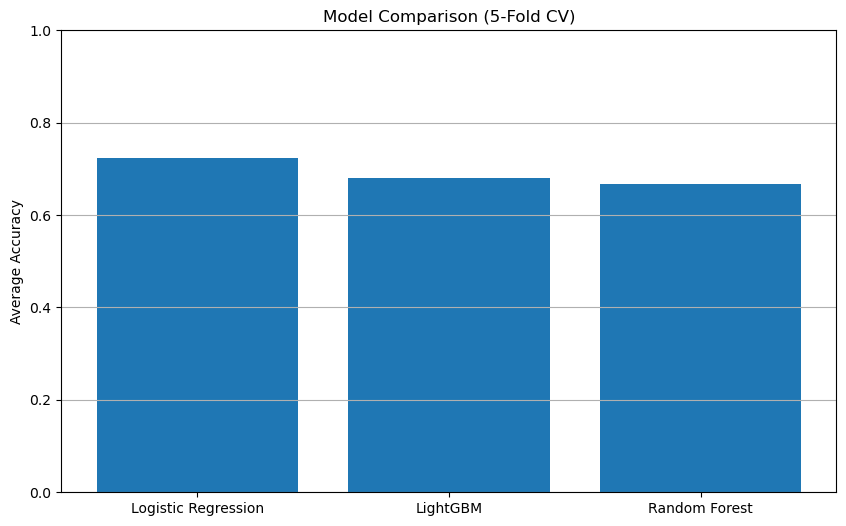


Best model selected: Logistic Regression
Best model retrained and saved successfully.
Test datasets loaded successfully.
Test data merged and cleaned.
Test features aligned successfully.
Scaling applied successfully.
Manually selected test features using saved importance list.
Prediction completed successfully.

Predictions saved to 'test_predictions1.csv'.
  participant_id  Sex_F_predicted  ADHD_Outcome_predicted
0   Cfwaf5FX7jWK                0                       1
2   ULliyEXjy4OV                0                       0
3   LZfeAb1xMtql                0                       1
4   EnFOUv0YK1RG                0                       1
6   PRKZcnOgqcuk                0                       0


In [21]:
# =========================
# --- Feature Selection, Model Training, and Test Prediction (Fully Annotated) ---
# =========================

from sklearn.feature_selection import SelectFromModel  # Optional, not used directly in this pipeline
from sklearn.model_selection import KFold, StratifiedKFold  # For cross-validation

# Step 1: Split features and targets
y = merged_data_impute[['Sex_F', 'ADHD_Outcome']]  # Define target variables (multi-output)
X = merged_data_impute.drop(['participant_id', 'Sex_F', 'ADHD_Outcome'], axis=1)  # Drop ID and target columns

# Save column names for test-time alignment
joblib.dump(X.columns.tolist(), "train_columns.joblib")
print("Training feature columns saved.")

# =========================
# --- Standardize Features ---
# =========================
try:
    scaler = StandardScaler()  # Initialize the scaler
    X_scaled = scaler.fit_transform(X)  # Fit and transform the features
    joblib.dump(scaler, "scaler.joblib")  # Save scaler for later use
    print("Standardization applied and scaler saved.")
except Exception as e:
    print("Error during standardization.", e)
    raise

# =========================
# --- Feature Selection using Random Forest ---
# =========================
try:
    rf = RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=108)  # Use balanced weights
    rf.fit(X_scaled, y['ADHD_Outcome'])  # Fit on ADHD_Outcome only

    importances = rf.feature_importances_  # Get feature importances
    feature_names = np.array(X.columns)  # Get feature names

    # Plot top 20 features
    top_n = 20
    indices = np.argsort(importances)[-top_n:]

    plt.figure(figsize=(10, 6))
    plt.barh(range(top_n), importances[indices], align='center')
    plt.yticks(range(top_n), feature_names[indices])
    plt.xlabel('Feature Importance')
    plt.title(f'Top {top_n} Features from Random Forest')
    plt.grid()
    plt.tight_layout()
    plt.show()

    # Apply manual thresholding
    importance_threshold = 0.004
    selected_mask = importances >= importance_threshold
    selected_features = feature_names[selected_mask]
    print(f"Selected {len(selected_features)} features with importance >= {importance_threshold}")

    # Filter scaled features
    X_selected = X_scaled[:, selected_mask]

    # Save selected features for test-time use
    joblib.dump(selected_features.tolist(), "selected_feature_names.joblib")
    joblib.dump(rf, "feature_selector_model.joblib")

except Exception as e:
    print("Error during feature selection and plotting.", e)
    raise

# =========================
# --- Model Training & 5-Fold Cross-Validation ---
# =========================

models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=108),
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'LightGBM': LGBMClassifier(random_state=108)
}

def multioutput_accuracy_per_target(y_true, y_pred):
    adhd_acc = accuracy_score(y_true[:, 1], y_pred[:, 1])
    sex_acc = accuracy_score(y_true[:, 0], y_pred[:, 0])
    avg_acc = np.mean([adhd_acc, sex_acc])
    return adhd_acc, sex_acc, avg_acc

results = []
kf = KFold(n_splits=5, shuffle=True, random_state=108)

for name, base_model in models.items():
    print(f"\nEvaluating {name}...")
    model = MultiOutputClassifier(base_model)
    adhd_accuracies, sex_accuracies = [], []

    for train_idx, test_idx in kf.split(X_selected):
        X_train_cv, X_test_cv = X_selected[train_idx], X_selected[test_idx]
        y_train_cv, y_test_cv = y.values[train_idx], y.values[test_idx]

        model.fit(X_train_cv, y_train_cv)
        y_pred_cv = model.predict(X_test_cv)

        adhd_acc, sex_acc, _ = multioutput_accuracy_per_target(y_test_cv, y_pred_cv)
        adhd_accuracies.append(adhd_acc)
        sex_accuracies.append(sex_acc)

    mean_adhd_acc = np.mean(adhd_accuracies)
    mean_sex_acc = np.mean(sex_accuracies)
    avg_acc = np.mean([mean_adhd_acc, mean_sex_acc])

    results.append({
        'Model': name,
        'ADHD_Accuracy': mean_adhd_acc,
        'Sex_Accuracy': mean_sex_acc,
        'Average_Accuracy': avg_acc
    })

# Summarize performance
results_df = pd.DataFrame(results).sort_values(by='Average_Accuracy', ascending=False)
print("\nModel Comparison Summary:")
print(results_df)

# Plot model performance
plt.figure(figsize=(10,6))
plt.bar(results_df['Model'], results_df['Average_Accuracy'])
plt.ylabel('Average Accuracy')
plt.title('Model Comparison (5-Fold CV)')
plt.ylim(0, 1)
plt.grid(axis='y')
plt.show()

# =========================
# --- Retrain Best Model on Full Data ---
# =========================
try:
    best_model_name = results_df.iloc[0]['Model']  # Select best model
    print(f"\nBest model selected: {best_model_name}")

    base_model_mapping = {
        'Random Forest': RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=108),
        'Logistic Regression': LogisticRegression(max_iter=1000, class_weight='balanced'),
        'LightGBM': LGBMClassifier(random_state=108)
    }

    final_model = MultiOutputClassifier(base_model_mapping[best_model_name])  # Final model
    final_model.fit(X_selected, y)  # Train on full data
    joblib.dump(final_model, "random_forest_multioutput_model.joblib")  # Save model
    print("Best model retrained and saved successfully.")
except Exception as e:
    print("Error during final model training.", e)
    raise

# =========================
# --- Predict on Test Data ---
# =========================
try:
    categorical_test = pd.read_excel("widsdatathon2025/TEST/TEST_CATEGORICAL.xlsx")
    quantitative_test = pd.read_excel("widsdatathon2025/TEST/TEST_QUANTITATIVE_METADATA.xlsx")
    connectome_test = pd.read_csv("widsdatathon2025/TEST/TEST_FUNCTIONAL_CONNECTOME_MATRICES.csv")
    print("Test datasets loaded successfully.")
except Exception as e:
    print("Error loading test datasets.", e)
    raise

try:
    test_data_clean = categorical_test.merge(quantitative_test, on='participant_id', how='inner')
    test_data_clean = test_data_clean.merge(connectome_test, on='participant_id', how='inner')
    test_data_clean = test_data_clean.dropna()
    print("Test data merged and cleaned.")
except Exception as e:
    print("Error during test data merging.", e)
    raise

# Preprocess test features
try:
    participant_ids = test_data_clean['participant_id']  # Store IDs
    X_test = test_data_clean.drop(['participant_id'], axis=1)  # Remove ID

    train_columns = joblib.load("train_columns.joblib")  # Load original column names
    X_test = X_test[train_columns]  # Align columns
    print("Test features aligned successfully.")
except Exception as e:
    print("\nError: Test features do not match training features.", e)
    raise

try:
    scaler = joblib.load("scaler.joblib")  # Load scaler
    X_test_scaled = scaler.transform(X_test)  # Apply scaling
    print("Scaling applied successfully.")
except Exception as e:
    print("\nError during scaling of test set.", e)
    raise

# Apply feature selection mask manually
try:
    selected_feature_names = joblib.load("selected_feature_names.joblib")  # Load important features
    X_test_filtered = pd.DataFrame(X_test_scaled, columns=train_columns)[selected_feature_names]  # Filter test features
    X_test_selected = X_test_filtered.values  # Convert to array
    print("Manually selected test features using saved importance list.")
except Exception as e:
    print("\nError during manual test feature selection.", e)
    raise

# Predict on test data
try:
    best_model = joblib.load("random_forest_multioutput_model.joblib")  # Load best model
    y_pred_test = best_model.predict(X_test_selected)  # Make predictions
    print("Prediction completed successfully.")
except Exception as e:
    print("\nError during prediction.", e)
    raise

# Save predictions to CSV
try:
    submission_df = pd.DataFrame({
        'participant_id': participant_ids,
        'Sex_F_predicted': y_pred_test[:, 0],
        'ADHD_Outcome_predicted': y_pred_test[:, 1]
    })
    submission_df.to_csv("test_predictions1.csv", index=False)  # Save file
    print("\nPredictions saved to 'test_predictions1.csv'.")
    print(submission_df.head())
except Exception as e:
    print("\nError during saving predictions.", e)
    raise

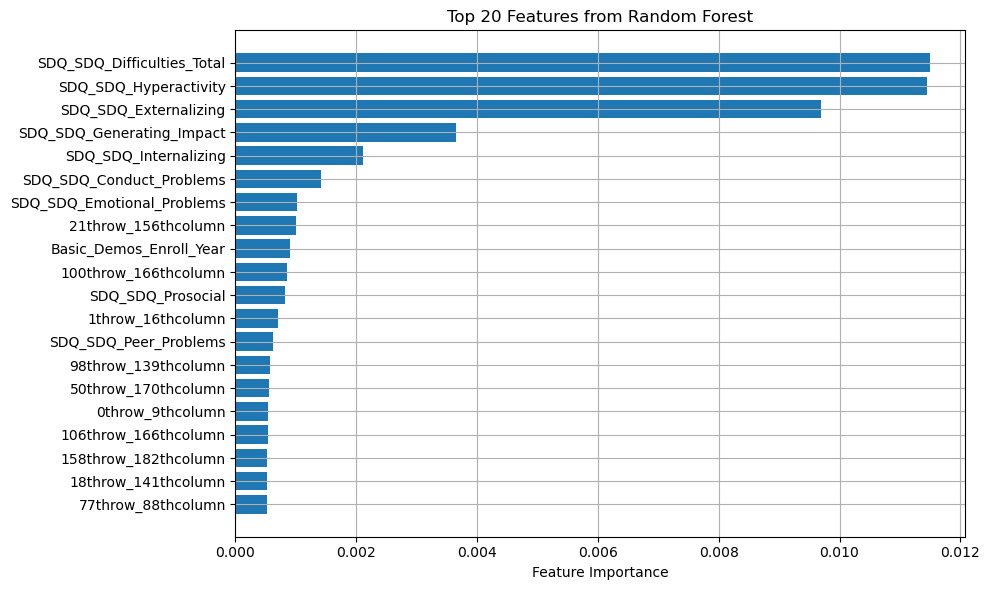

In [22]:
# =========================
# --- Visualize Top N Feature Importances from Random Forest ---
# =========================

# Train a Random Forest classifier with more trees (more stable importances)
rf = RandomForestClassifier(n_estimators=200, random_state=108)  # Higher n_estimators = more robust results
rf.fit(X_scaled, y['ADHD_Outcome'])  # Fit the model using only the ADHD_Outcome target

# Retrieve feature importances after training
importances = rf.feature_importances_  # Array of importance scores per feature
feature_names = X.columns  # Original feature names from training data

# Sort and select indices of top N most important features
top_n = 20  # Number of top features to display
indices = np.argsort(importances)[-top_n:]  # Get indices of top N features (ascending order)

# Plot top N feature importances as horizontal bar chart
plt.figure(figsize=(10, 6))  # Set plot dimensions
plt.barh(range(top_n), importances[indices], align='center')  # Horizontal bar plot of importance scores
plt.yticks(range(top_n), [feature_names[i] for i in indices])  # Label bars with corresponding feature names
plt.xlabel('Feature Importance')  # X-axis label
plt.title(f'Top {top_n} Features from Random Forest')  # Title of the plot
plt.tight_layout()  # Ensure layout fits labels
plt.grid()  # Add gridlines for clarity
plt.show()  # Display the plot

In [23]:
# =========================
# --- Analyze Class Distribution in Test Predictions ---
# =========================

# Load prediction results from CSV file
df = pd.read_csv("test_predictions1.csv")  # This file contains predicted labels for test samples

# Print class distribution for predicted Sex_F (0 = Not Female, 1 = Female)
print("Sex_F prediction counts:")
print(df["Sex_F_predicted"].value_counts())  # Count how many samples predicted as 0 or 1

# Print class distribution for predicted ADHD_Outcome (0 = No ADHD, 1 = ADHD)
print("\nADHD_Outcome prediction counts:")
print(df["ADHD_Outcome_predicted"].value_counts())  # Count how many samples predicted as 0 or 1


Sex_F prediction counts:
Sex_F_predicted
0    126
1     88
Name: count, dtype: int64

ADHD_Outcome prediction counts:
ADHD_Outcome_predicted
1    126
0     88
Name: count, dtype: int64


In [24]:
# =========================
# --- Analyze Class Distribution in Training Data ---
# =========================

# Print normalized distribution of actual classes in training data
print("Sex_F distribution:")
print(y["Sex_F"].value_counts(normalize=True))  # Proportion of 0s and 1s in 'Sex_F'

print("\nADHD_Outcome distribution:")
print(y["ADHD_Outcome"].value_counts(normalize=True))  # Proportion of 0s and 1s in 'ADHD_Outcome'



Sex_F distribution:
Sex_F
0    0.657049
1    0.342951
Name: proportion, dtype: float64

ADHD_Outcome distribution:
ADHD_Outcome
1    0.685078
0    0.314922
Name: proportion, dtype: float64


In [25]:
# =========================
# --- Classification Report (Sex_F: Female = 1) ---
# =========================

# Print detailed classification report for Sex_F (0 = Male, 1 = Female)
print(classification_report(y_test, y_pred, target_names=['Not female', 'Female']))  # Includes precision, recall, F1


              precision    recall  f1-score   support

  Not female       0.59      0.23      0.33        73
      Female       0.77      0.91      0.84       157

   micro avg       0.75      0.70      0.72       230
   macro avg       0.68      0.57      0.58       230
weighted avg       0.71      0.70      0.68       230
 samples avg       0.60      0.56      0.57       230



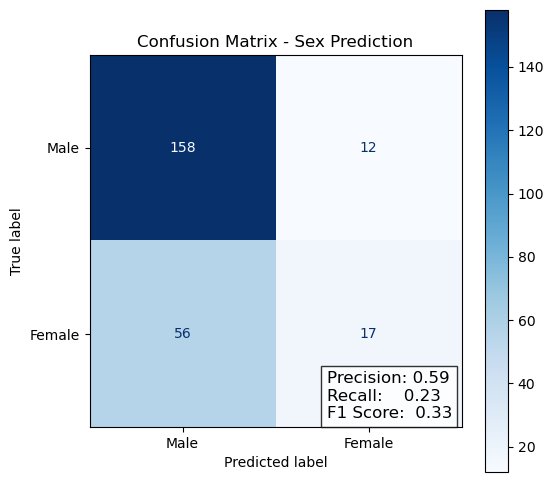

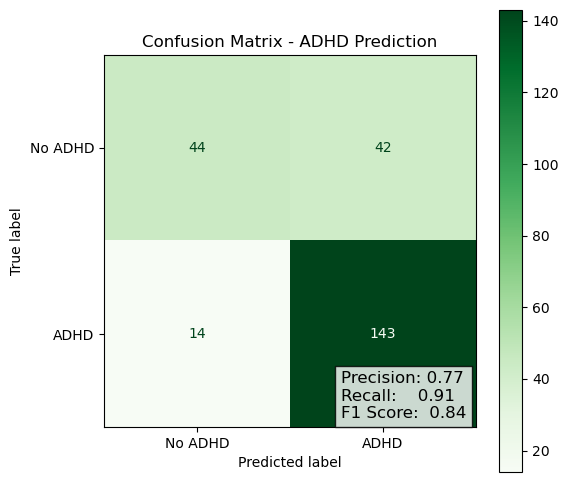

In [32]:
# =========================
# --- Confusion Matrices for Sex_F and ADHD_Outcome ---
# =========================

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay  # For confusion matrix visualizations

# --- Confusion Matrix for Sex_F ---
try:
    y_true_sex = y_test['Sex_F'].values  # True binary labels for Sex_F
    y_pred_sex = y_pred[:, 0]  # Predicted binary labels for Sex_F
    
    cm_sex = confusion_matrix(y_true_sex, y_pred_sex)  # Compute confusion matrix
    
    # Calculate precision, recall, F1 for Female (positive class = 1)
    precision_sex = precision_score(y_true_sex, y_pred_sex, zero_division=0)
    recall_sex = recall_score(y_true_sex, y_pred_sex, zero_division=0)
    f1_sex = f1_score(y_true_sex, y_pred_sex, zero_division=0)

    disp_sex = ConfusionMatrixDisplay(confusion_matrix=cm_sex, display_labels=['Male', 'Female'])

    fig, ax = plt.subplots(figsize=(6, 6))  # Define plot size
    disp_sex.plot(ax=ax, cmap='Blues')  # Display matrix with blue color scheme
    metrics_text_sex = (
        f'Precision: {precision_sex:.2f}\n'
        f'Recall:    {recall_sex:.2f}\n'
        f'F1 Score:  {f1_sex:.2f}'
    )
    plt.title("Confusion Matrix - Sex Prediction")  # Title for the matrix
    plt.gcf().text(0.52, 0.2, metrics_text_sex, fontsize=12, bbox=dict(facecolor='white', alpha=0.8))
    plt.show()  # Display the plot

except Exception as e:
    print("Error plotting Sex_F confusion matrix:", e)

# --- Confusion Matrix for ADHD_Outcome ---
try:
    y_true_adhd = y_test['ADHD_Outcome'].values  # True labels for ADHD
    y_pred_adhd = y_pred[:, 1]  # Predicted labels for ADHD

    cm_adhd = confusion_matrix(y_true_adhd, y_pred_adhd)  # Compute confusion matrix

 # Compute metrics for ADHD (positive class = 1)
    precision_adhd = precision_score(y_true_adhd, y_pred_adhd, zero_division=0)
    recall_adhd = recall_score(y_true_adhd, y_pred_adhd, zero_division=0)
    f1_adhd = f1_score(y_true_adhd, y_pred_adhd, zero_division=0)

    disp_adhd = ConfusionMatrixDisplay(confusion_matrix=cm_adhd, display_labels=['No ADHD', 'ADHD'])

    fig, ax = plt.subplots(figsize=(6, 6))  # Define plot size
    disp_adhd.plot(ax=ax, cmap='Greens')  # Display matrix with green color scheme
    metrics_text_adhd = (
        f'Precision: {precision_adhd:.2f}\n'
        f'Recall:    {recall_adhd:.2f}\n'
        f'F1 Score:  {f1_adhd:.2f}'
    )
    plt.title("Confusion Matrix - ADHD Prediction")  # Title for the matrix
    plt.gcf().text(0.52, 0.2, metrics_text_adhd, fontsize=12, bbox=dict(facecolor='white', alpha=0.8))
    plt.show()  # Display the plot

except Exception as e:
    print("Error plotting ADHD_Outcome confusion matrix:", e)